# Урок 4. Деревья решений

Функции и расчеты с лекции:

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, r2_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)
# classification_data, classification_labels = make_circles(n_samples=50, random_state=5)

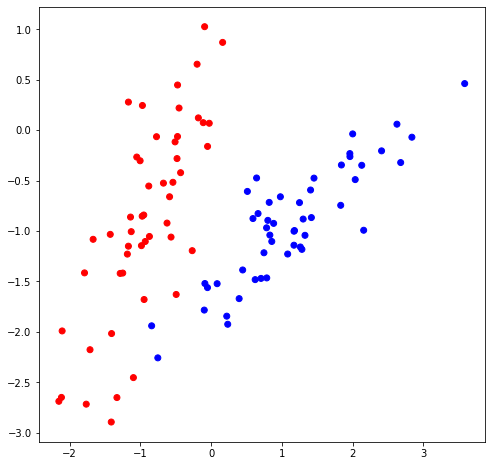

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    import time
    print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels)
    
    print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [14]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

1634983027.933443 <__main__.Leaf object at 0x11c5ec820>
1634983027.938427 <__main__.Leaf object at 0x11c6021c0>
1634983027.9388092 <__main__.Node object at 0x11c5ec940>
1634983027.940924 <__main__.Leaf object at 0x11c5ec7f0>
1634983027.9411042 <__main__.Node object at 0x11c6027f0>
1634983027.9463549 <__main__.Leaf object at 0x11c5eccd0>


In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0 <= 0.16261402870113306
--> True:
  Индекс 1 <= -1.5208896621663803
  --> True:
    Индекс 0 <= -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [16]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [17]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [18]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [19]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

In [20]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

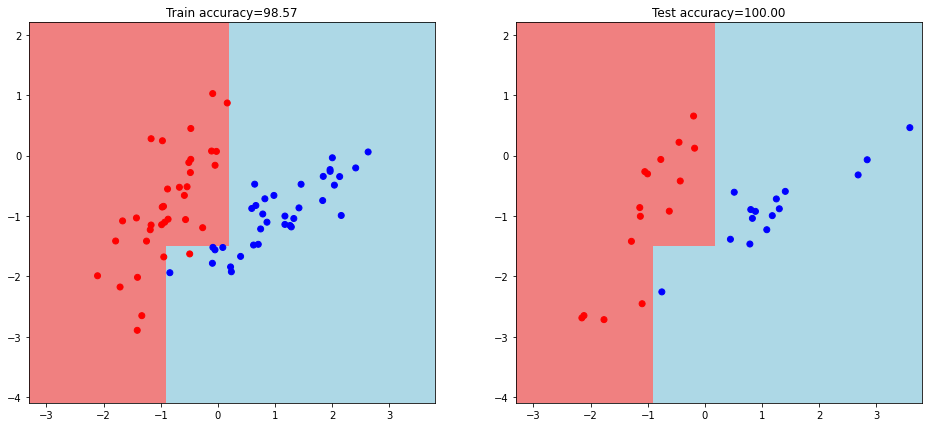

In [21]:
visualize(train_data, test_data)

# Домашнее задание

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

Реализуем критерий останова, ограничивающий максимальную глубину дерева.

Во-первых, удалим в функции `find_best_split` строки, касающиеся минимального количества объектов в узле, в остальном оставляем ее без изменений.

In [22]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):


    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

Во-вторых, изменим функцию, отвечающую за построение дерева. Добавим параметр `max_depth`, который задает максимально возможную глубину дерева. Пропишем дополнительное условие остановки построения дерева, когда мы достигли разрешенной глубины.

In [23]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth=3):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества, или же мы достигли максимальной глубины
    if (gain == 0) or (max_depth == 0):
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева, уменьшаем параметр max_depth на 1
    true_branch = build_tree(true_data, true_labels, max_depth=max_depth-1)
    import time
    print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_labels, max_depth=max_depth-1)
    
    print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [24]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

1634983028.936946 <__main__.Leaf object at 0x11c622220>
1634983028.937535 <__main__.Leaf object at 0x11c6ada00>
1634983028.9375901 <__main__.Node object at 0x11c6b4be0>
1634983028.943882 <__main__.Leaf object at 0x11c6ad970>
1634983028.951964 <__main__.Node object at 0x11c6ad880>
1634983028.973383 <__main__.Leaf object at 0x11c6ad460>


In [25]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0 <= 0.16261402870113306
--> True:
  Индекс 1 <= -1.5208896621663803
  --> True:
    Индекс 0 <= -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [26]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [27]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [28]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [29]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

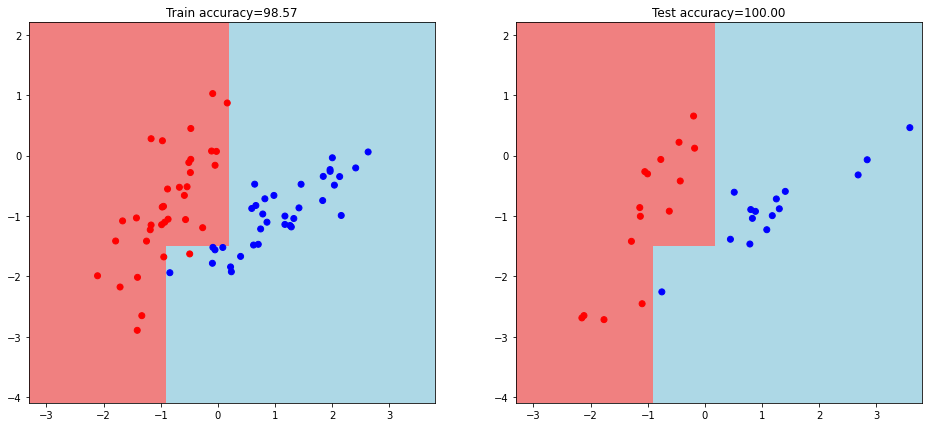

In [30]:
visualize(train_data, test_data)

2. *Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

Модифицируем некоторые функции, чтобы построенную модель дерева можно было использовать для решения задач регрессии. Прежде всего заменим механизм предсказания в классе `Leaf`. Класс `Node` оставим без изменения.

In [31]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [32]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, values):
        self.data = data
        self.values = values
        self.prediction = self.predict()
        
    def predict(self):
        # Рассчитываем среднее значение
        return np.mean(self.values)        

Перепишем также функцию, которая отвечает за расчет прироста информации при делении узла, таким образом, что вычисления происходили на основе дисперсии. Функцию, отвечающую за разбиение, не меняем.

In [33]:
# Расчет прироста

def gain(left_values, right_values, root_var):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_values.shape[0]) / (left_values.shape[0] + right_values.shape[0])
    
    return root_var - p * np.var(left_values) - (1 - p) * np.var(right_values)

In [34]:
# Разбиение датасета в узле

def split(data, values, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_values = values[left]
    false_values = values[right]
        
    return true_data, false_data, true_values, false_values

Изменим еще строчку в функции, которая ищет наилучшее разбиение, чтобы она также учитывала дисперсию значений, а не коэффициент Джини.

In [35]:
# Нахождение наилучшего разбиения

def find_best_split(data, values):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    # В начальном узле, который будем делить, считаем дисперсию
    root_var = np.var(values)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_data = np.unique(data[:, index])
        
        for t in t_data:
            true_data, false_data, true_values, false_values = split(data, values, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_values, false_values, root_var)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

Остальные функции можно оставить без изменений.

In [36]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, values):

    gain, t, index = find_best_split(data, values)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, values)

    true_data, false_data, true_values, false_values = split(data, values, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_values)
    import time
    print(time.time(), true_branch)
    false_branch = build_tree(false_data, false_values)
    
    print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [37]:
def predict_value(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return predict_value(obj, node.true_branch)
    else:
        return predict_value(obj, node.false_branch)

In [38]:
def predict(data, tree):
    
    values = []
    for obj in data:
        prediction = predict_value(obj, tree)
        values.append(prediction)
    return values

Теперь проверим работу получившейся модели на сгенерированных данных.

In [39]:
X, Y, coef = make_regression(n_samples=1000, n_features=2, n_informative=2, n_targets=1, 
                                      noise=5, coef=True, random_state=1)

In [40]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_values, test_values = train_test_split(X, 
                                                                    Y, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [41]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_values)

1634983030.520891 <__main__.Leaf object at 0x11c75dfd0>
1634983030.5222158 <__main__.Leaf object at 0x11c795cd0>
1634983030.527966 <__main__.Node object at 0x11c795fa0>
1634983030.539192 <__main__.Leaf object at 0x11c777220>
1634983030.546869 <__main__.Leaf object at 0x11c795d90>
1634983030.547651 <__main__.Leaf object at 0x11c795fd0>
1634983030.5477052 <__main__.Node object at 0x11c7954c0>
1634983030.54776 <__main__.Node object at 0x11c795c40>
1634983030.5478 <__main__.Node object at 0x11c7a80a0>
1634983030.6821141 <__main__.Leaf object at 0x11c7957c0>
1634983030.689141 <__main__.Leaf object at 0x11c7955b0>
1634983030.6904728 <__main__.Node object at 0x11c795b50>
1634983030.6989498 <__main__.Leaf object at 0x11c7955e0>
1634983030.70322 <__main__.Leaf object at 0x11c795700>
1634983030.7041569 <__main__.Leaf object at 0x11c795910>
1634983030.708995 <__main__.Node object at 0x11c795640>
1634983030.709322 <__main__.Node object at 0x11c795a00>
1634983030.716036 <__main__.Leaf object at 0x1

1634983031.6177878 <__main__.Leaf object at 0x11c7b1e20>
1634983031.619078 <__main__.Leaf object at 0x11c7b1eb0>
1634983031.619253 <__main__.Node object at 0x11c7b3040>
1634983031.61962 <__main__.Leaf object at 0x11c7b3460>
1634983031.619671 <__main__.Node object at 0x11c7b3610>
1634983031.6579251 <__main__.Leaf object at 0x11c7b1df0>
1634983031.6590002 <__main__.Leaf object at 0x11c7b36d0>
1634983031.660425 <__main__.Node object at 0x11c7b37c0>
1634983031.6656399 <__main__.Leaf object at 0x11c7b1fd0>
1634983031.667851 <__main__.Leaf object at 0x11c7b1e80>
1634983031.668203 <__main__.Node object at 0x11c7b34f0>
1634983031.668247 <__main__.Node object at 0x11c7b35b0>
1634983031.668876 <__main__.Leaf object at 0x11c7b1ee0>
1634983031.6690361 <__main__.Node object at 0x11c7b30d0>
1634983031.677921 <__main__.Leaf object at 0x11c7b3310>
1634983031.684607 <__main__.Leaf object at 0x11c7b3370>
1634983031.684997 <__main__.Node object at 0x11c7b33d0>
1634983031.687938 <__main__.Leaf object at 0

In [42]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1 <= 0.07487609788866709
--> True:
  Индекс 1 <= -0.8155473512047462
  --> True:
    Индекс 1 <= -1.7745959882248337
    --> True:
      Индекс 1 <= -2.2271126318500145
      --> True:
        Индекс 0 <= -1.2133381258287046
        --> True:
          Прогноз: -249.94570136658453
        --> False:
          Прогноз: -225.01120037738386
      --> False:
        Индекс 0 <= -0.5889311760437443
        --> True:
          Прогноз: -197.9136433452496
        --> False:
          Индекс 1 <= -1.9987639441733347
          --> True:
            Прогноз: -171.9033039655334
          --> False:
            Прогноз: -154.6117321057729
    --> False:
      Индекс 1 <= -1.2704607763854796
      --> True:
        Индекс 0 <= 0.10059341767972574
        --> True:
          Индекс 1 <= -1.5387932457446432
          --> True:
            Прогноз: -148.1089401714187
          --> False:
            Прогноз: -130.07389478730232
        --> False:
          Индекс 0 <= 1.0138224669717055
       

          Индекс 0 <= 0.43912737321880185
          --> True:
            Индекс 1 <= 0.8575475535903946
            --> True:
              Прогноз: 72.09089673663034
            --> False:
              Прогноз: 83.09400693381521
          --> False:
            Индекс 0 <= 1.0444420947072588
            --> True:
              Прогноз: 88.35881379422341
            --> False:
              Прогноз: 95.60094460347773
  --> False:
    Индекс 1 <= 1.5045218666646716
    --> True:
      Индекс 0 <= -0.6284625527547907
      --> True:
        Индекс 1 <= 1.2179409008013473
        --> True:
          Индекс 0 <= -1.229574253546429
          --> True:
            Прогноз: 63.13159848762391
          --> False:
            Прогноз: 81.62449871086277
        --> False:
          Прогноз: 105.24185735350743
      --> False:
        Индекс 1 <= 1.167075165999964
        --> True:
          Индекс 0 <= 1.0414396343771428
          --> True:
            Индекс 0 <= 0.11197268749652817
         

In [43]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [44]:
r2_score(train_answers, train_values)

0.9945961555875618

In [45]:
r2_score(answers, test_values)

0.9785598583201649

Сравним с результатами, которые можно получить с помощью модели `DecisionTreeRegressor` из модуля sklearn.

In [46]:
model = DecisionTreeRegressor(min_samples_leaf=5, random_state=1)
model.fit(train_data, train_values)

DecisionTreeRegressor(min_samples_leaf=5, random_state=1)

In [47]:
train_answers_sk = model.predict(train_data)
r2_score(train_answers_sk, train_values)

0.9945961555875618

In [48]:
answers_sk = model.predict(test_data)
r2_score(answers_sk, test_values)

0.9799044954219035